<a href="https://colab.research.google.com/github/awhooshingwind/colab_notebooks/blob/main/astr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I tried to add comments to explain what's going on throughout, but I chose a Google Colab notebook for this project for portability (I've been traveling, and my chromebook I used for school doesn't quite have the processing power to tackle this much data reliably) and so there wouldn't be any additonal set-up, data to include in the project submission, everything is contained within this notebook instance.

The commented-out code is mostly leftover from my own testing or to suppress some messy/length output from some of the query results/data truncation.

The various headings can be run all at once to get to the final output, or expanded and run cell by cell if you want to see what's going on in more detail.

# Set up
Library install and imports

## Installs and imports

In [1]:
!pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 7.0 MB/s 
     |████████████████████████████████| 832 kB 46.2 MB/s 
     |████████████████████████████████| 48 kB 3.4 MB/s 
     |████████████████████████████████| 4.1 MB 36.9 MB/s 


In [2]:
!pip install reproject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 9.1 MB/s 
     |████████████████████████████████| 208 kB 40.1 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import math

from astropy.io import fits
from astropy import coordinates, units as u, wcs
from astropy.table import Table

from astroquery.mast import Observations
from astroquery.simbad import Simbad
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from astroquery.vo_conesearch import ConeSearch

import pylab as pl
from PIL import Image


# Project Start

## Function definition, list of stars in Cancer to query

In [4]:
# Function Definitions
''' Given a list of star names,
return a dictionary 
{star name: SkyCoord coordinate object}
'''
def get_coords(list_of_stars):
  coords =[]
  for star in list_of_stars:
    coords.append(coordinates.SkyCoord.from_name(star))
  return dict(zip(list_of_stars, coords))

''' Given a dictionary of star tables,
list of column titles to save, and optional style keyword,
return a truncated dictionary of 
{ID: (Tuple of Kept Data)}
Note: given GSC2 styling, will return
{hstID: (Mag, B-V index)}
'''
# Note, this should be reworked to just use and return astropy tables instead of the dict wrapper
def trunc_table(star_table_dict, colm_names, style=None):
  trunc_mag= {}
  for s, t in star_table_dict.items():
    # Verbose printing, uncomment for testing
    # print(str(s) + ': ')
    # t[[col for col in colm_names]].pprint()
    if style == 'GSC2': # used in the VO cone search, functional but real messy
      for i in range(len(t)):
        if t['class'][i] <= 2 and t['BMag'][i]-t['VMag'][i] < 15 and t['BMag'][i]-t['VMag'][i] > -10:
          tmp_str = t['hstID'][i]
          tmp_data = (t['Mag'][i], t['BMag'][i] - t['VMag'][i])
          trunc_mag[tmp_str] = tmp_data
    elif not style:
      id_str = colm_names[0]
      other_data = colm_names[1:-1]
      for i in range(len(t)):
        tmp_str = t[id_str][i]
        tmp_data = np.array(list(t[other_data][i]))
        tmp_data[np.isnan(tmp_data)] = 0 # or -1? not sure how to best handle nan
        # print(tmp_str, tmp_data)
        trunc_mag[tmp_str] = tmp_data
  return trunc_mag

The absolute magnitude M can also be written in terms of the apparent magnitude m and stellar parallax p:

$$ M=m+5\left(\log _{10}p+1\right),$$ 

or using apparent magnitude m and distance modulus μ:

$$ M=m-\mu $$

In [5]:
# Astro Formulae
# absolute magnitude (beta canc wiki data example)
# p = 10.75/1000
# print(3.52 - (5*math.log10(1/p)-5))
# print(3.52 + 5*(math.log10(p) + 1))
# For simplicitiy, use V mag for apparent
def abs_mag(app_mag, parallax, mas=False):
  if mas:
    parallax = parallax/1000
  return app_mag + 5*(math.log10(parallax)+1)

# print(abs_mag(3.52, p))
# print(abs_mag(3.52, 10.75, mas=True))
# IR Color-color 
# J-H(y ax) vs H-K(x ax)

In [ ]:
coordinates.SkyCoord.from_name('Zeta Cancri')

<SkyCoord (ICRS): (ra, dec) in deg
    (123.05302654, 17.64776708)>

In [6]:
stars_in_cancer = [
    'Tarf', # Beta Cancri
    'Asellus Australis', # Delta Cancri
    'Iota Cancri', 
    'Acubens', # Alpha Cancri
    'Asellus Borealis', # Gamma Cancri
    'Tegmine', # Zeta Cancri
    'M44', # Beehive Cluster
]

cancer_coords = get_coords(stars_in_cancer)
print(cancer_coords)

{'Tarf': <SkyCoord (ICRS): (ra, dec) in deg
    (124.12883753, 9.18554387)>, 'Asellus Australis': <SkyCoord (ICRS): (ra, dec) in deg
    (131.17124671, 18.1543065)>, 'Iota Cancri': <SkyCoord (ICRS): (ra, dec) in deg
    (131.67425182, 28.75989314)>, 'Acubens': <SkyCoord (ICRS): (ra, dec) in deg
    (134.62168421, 11.8576804)>, 'Asellus Borealis': <SkyCoord (ICRS): (ra, dec) in deg
    (130.82145083, 21.46850022)>, 'Tegmine': <SkyCoord (ICRS): (ra, dec) in deg
    (123.05302654, 17.64776708)>, 'M44': <SkyCoord (ICRS): (ra, dec) in deg
    (130.054, 19.621)>}


## Data Queries

---

Get relevant data from SIMBAD database

In [ ]:
# Simbad.list_votable_fields() 

In [7]:
# Simbad.reset_votable_fields() # for testing
Simbad.add_votable_fields('distance','flux(U)', 'flux(B)','flux(V)','flux(J)', 'flux(H)', 'flux(K)', 'parallax','sptype')
# Simbad.get_votable_fields() # to confirm

In [8]:
# SIMBAD query, customized output columns
narrow_table = Simbad.query_objects(stars_in_cancer)
# narrow_table.pprint_all() # for testing
# narrow_table.colnames
narrow_col = [
    'MAIN_ID',
    'Distance_distance',
    'FLUX_U',
    'FLUX_B',
    'FLUX_V',
    'FLUX_J',
    'FLUX_H',
    'FLUX_K',
    'PLX_VALUE',
    'SP_TYPE'
]
narrow_table[[n for n in narrow_col]].pprint() # prints data for main stars

 MAIN_ID  Distance_distance FLUX_U FLUX_B ... FLUX_K PLX_VALUE      SP_TYPE     
                             mag    mag   ...  mag      mas                     
--------- ----------------- ------ ------ ... ------ --------- -----------------
* bet Cnc           98.9844   6.75    5.0 ...   0.14    10.750       K4IIIBa0.5:
* del Cnc           40.6002   6.01   5.02 ...  1.491    24.980           K0+IIIb
* iot Cnc          106.2430     --  4.996 ...  1.831     9.412       G8IIIaBa0.2
* alf Cnc           54.5540     --  4.388 ...   3.94    18.330 kA7VmF0/2III/IVSr
* gam Cnc           50.8864     --   4.67 ...  4.638    18.000              A1IV
* zet Cnc                --     --     -- ...   3.76    39.870           F8V+G0V
NGC  2632          187.0000     --     -- ...     --     5.371                  


In [9]:
narrow_data = np.array(narrow_table[[n for n in narrow_col]])
print(narrow_data)

[('* bet Cnc',  98.9844, 6.75, 5.   , 3.52 , 1.06 , 0.28 , 0.14 , 10.75  , 'K4IIIBa0.5:')
 ('* del Cnc',  40.6002, 6.01, 5.02 , 3.94 , 2.135, 1.604, 1.491, 24.98  , 'K0+IIIb')
 ('* iot Cnc', 106.243 ,  nan, 4.996, 4.018, 2.368, 1.941, 1.831,  9.4124, 'G8IIIaBa0.2')
 ('* alf Cnc',  54.554 ,  nan, 4.388, 4.249, 3.98 , 4.03 , 3.94 , 18.3304, 'kA7VmF0/2III/IVSr')
 ('* gam Cnc',  50.8864,  nan, 4.67 , 4.652, 4.799, 4.788, 4.638, 18.    , 'A1IV')
 ('* zet Cnc',      nan,  nan,   nan,   nan, 3.11 , 2.88 , 3.76 , 39.87  , 'F8V+G0V')
 ('NGC  2632', 187.    ,  nan,   nan,   nan,   nan,   nan,   nan,  5.371 , '')]


In [10]:
# Radii greater than 0.1 make the marker scaling blow up
# haven't tracked down which objects are causing it yet
radius = 0.1 * u.deg
big_table = {}

for star, coord in cancer_coords.items():
  big_table[star] = Simbad.query_region(coord, radius)
# big_table # for inspecting output, gets messy

In [ ]:
trunc_sim = trunc_table(big_table, narrow_col)
print(narrow_col)
# for tbl in trunc_sim.values():
#   print(tbl) # for inspecting truncation, also gets messy

In [27]:
# In this table, B = col [2], V = col [3] J-K in [4-6], parallax [7]
plt_mag = []
plt_bvi = []
plt_HK = []
plt_JH = []

for k, v in trunc_sim.items():
  # print(v[3], v[7]) # for testing
  if (v[3] >0 and v[7] > 0) and (v[2] >0 and v[3] > 0):
    tmag = abs_mag(v[3], v[7], mas=True)
    # print(tmag) # for testing
    plt_mag.append(tmag)
    # print(v[2], v[3]) # for testing/error checking
    tbvi = v[2] - v[3]
    plt_bvi.append(tbvi)
  if v[4] > 0 and v[5] > 0 and v[6] > 0:
    tmp_HK = v[5] - v[6]
    tmp_JH = v[5] - v[4]
    plt_HK.append(tmp_HK)
    plt_JH.append(tmp_JH)
  # print(k, v)

# confirm same length for plotting
print(len(plt_mag), len(plt_bvi)) 
print(len(plt_HK), len(plt_JH))

46 46
63 63


## Output
H-R Diagrams and a Color-color diagram

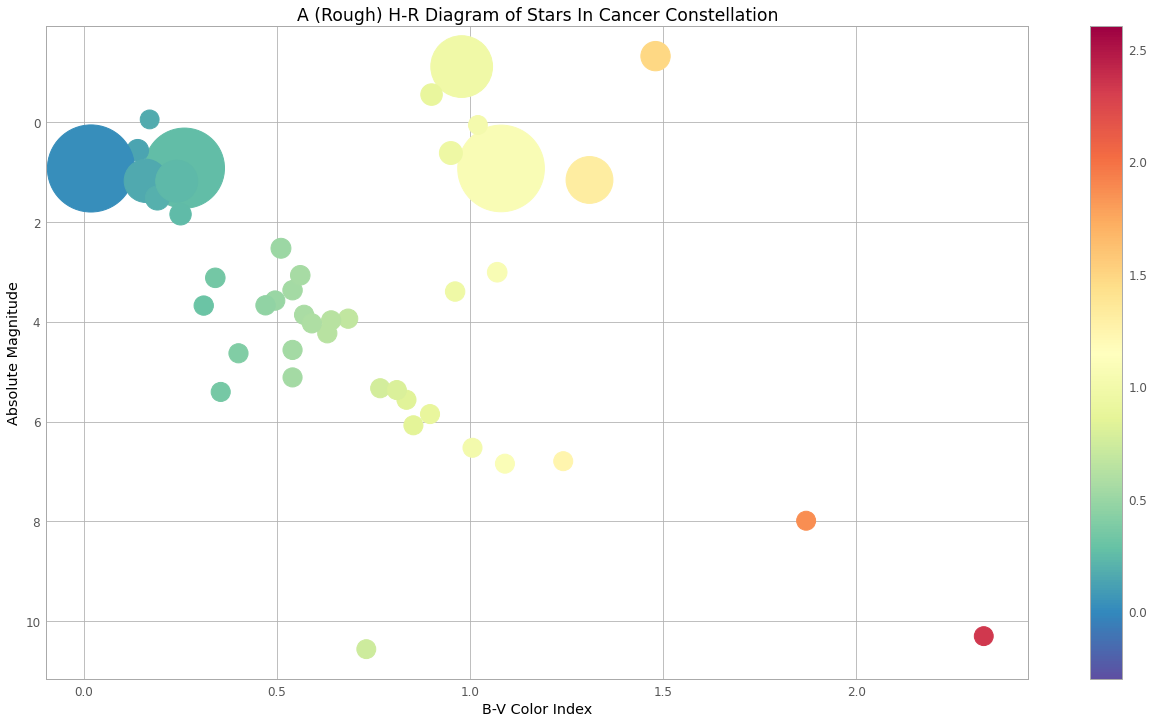

In [127]:
fig = plt.figure(figsize=(22,12))
# This is kinda wonky, just lots of trial and error guesswork, but I'm sure a proper
# formula could get the marker sizes to scale appropriately, color map is not accurate
# but probably be manually calibrated (even fter adjusting the norms, there's still a weird green band)
plt_s = [40/np.log(abs(mag))**2 + 350 for mag in plt_mag]
plt.scatter(plt_bvi, plt_mag, c=plt_bvi, cmap='Spectral_r', s=plt_s, norm = mpl.colors.Normalize(vmin=-0.3, vmax=2.6))
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('A (Rough) H-R Diagram of Stars In Cancer Constellation')
plt.xlabel('B-V Color Index')
plt.ylabel('Absolute Magnitude')
plt.show()

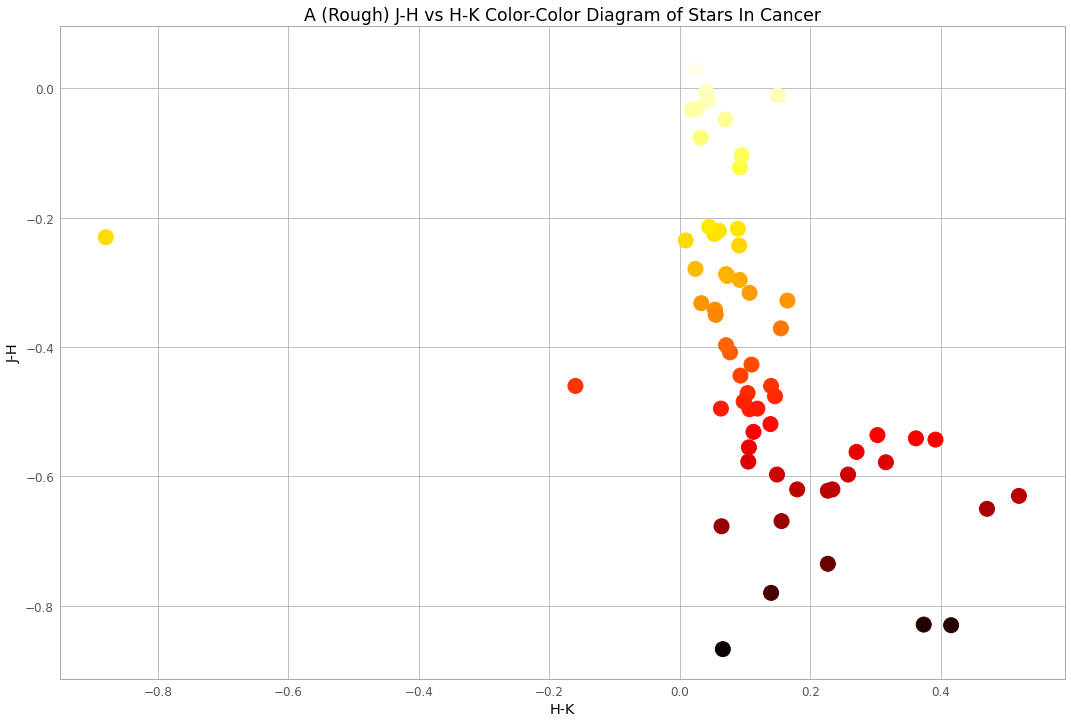

In [128]:
fig = plt.figure(figsize=(18,12))
# Attemtping a J-H vs H-K diagram for same group of stars
# Better filtering could be applied to only show stars in the IR range
plt.scatter(plt_HK, plt_JH, c=plt_JH, cmap='hot', s=15**2)
plt.title('A (Rough) J-H vs H-K Color-Color Diagram of Stars In Cancer')
plt.xlabel('H-K')
plt.ylabel('J-H')
plt.show()

# Appendix

Everything below here is included just for reference, not part of the main project for submission, more to show the progression of how I ended up with the above code and data queries. There's some playing around with overlaying Vizier data on SkyView images displaying some various telescope images in different formats (jpeg, fits)...wasn't too sure how to make something relevant from this, so I instead tried to apply what I know and try to make the above diagrams.

Not super sure how to interpret the J-H vs H-K diagram, but saw it referenced in the research I was doing while reading through documentation, so I thought I'd take a crack at one.

## Closing thoughts/future to dos:

This was a fun way to familiarize myself with some of these python astronomy libraries. I'm not (yet) super confident in how I applied the data I pulled from the queries, but really enjoyed the process. I feel most confident about the magnitude calculations (I checked a few from the named stars in cancer and was getting results pretty close to the accepted measurements I could find).

As mentioned in the code comments, I just fiddled with the equation to adjust the marker sizes on the HR plot, same with the colormap normalization. I'm sure there is a more accurate way to get that data to more accurately represent the star size/color, but that's a bit beyond my skill level (astronomically and programmaticall), at least for now.

I'll probably keep tweaking this code after this class - so I've included a to-do list for potential improvements to consider (any comments would be certainly appreciated!).

TO-DO:
- Generalize the code to look for stars in any constellation, not just cancer
- Add a wikipedia web-scraper to find a given number of named stars from a particular constellation?
- Add an option to search for just any named object, but apply the same logic and enable wider search radii (before things start to break/get wonky)
- Fix the marker size scaling equation to more accurately represent star size (maybe include a luminosity/radius function as the basis for scaling?)
- Make the color map more accurate - either define a custom one (yikes) or find a way to exclude certain ranges (so there aren't green stars in transitional bands)
- Add some patches/text to the H-R diagram, or a main sequence line for better context/comparison
- Incorporate the SkyView/MAST image code to overlay (or at least display) an optical image of the region being queried (see attempt immediately below)

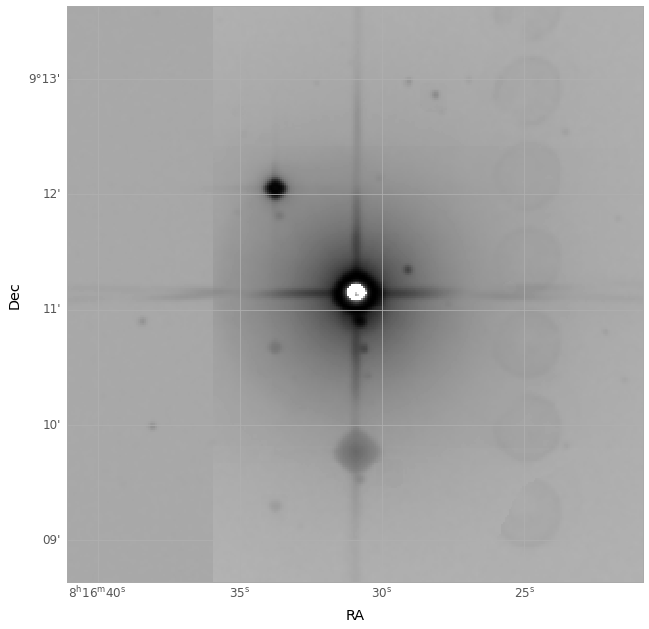

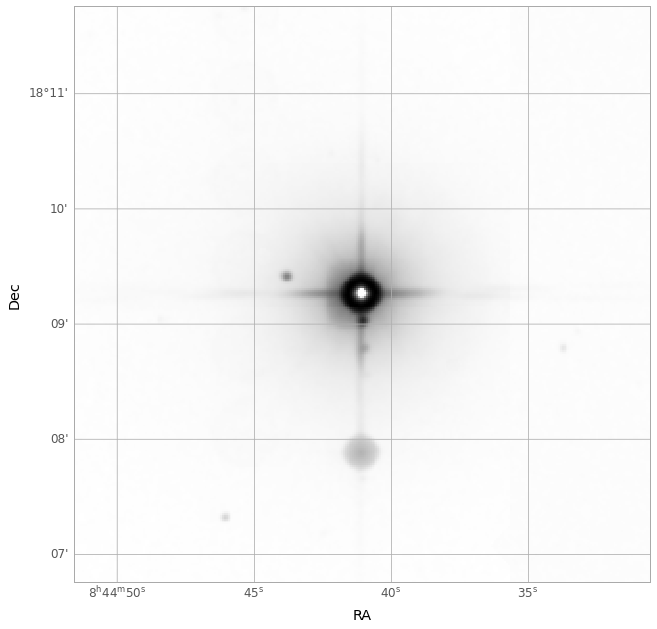

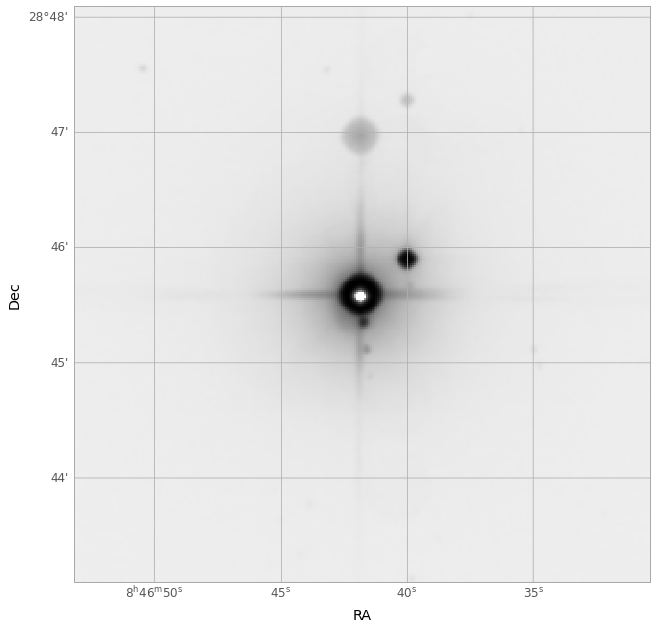

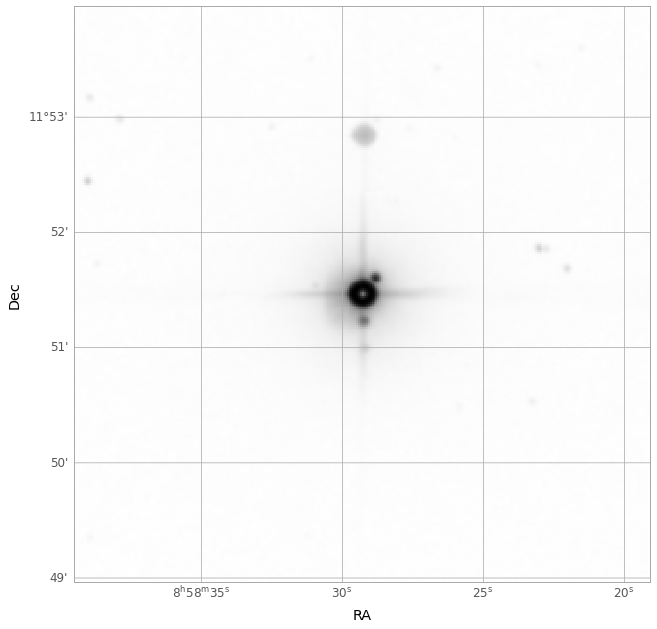

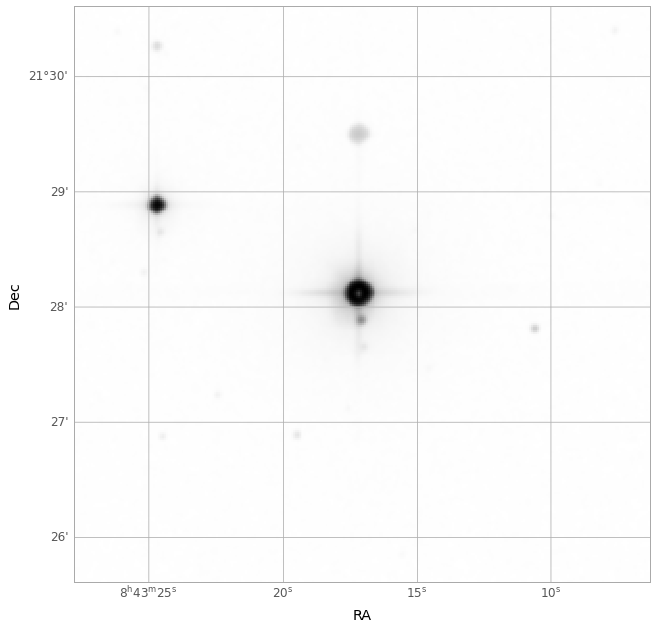

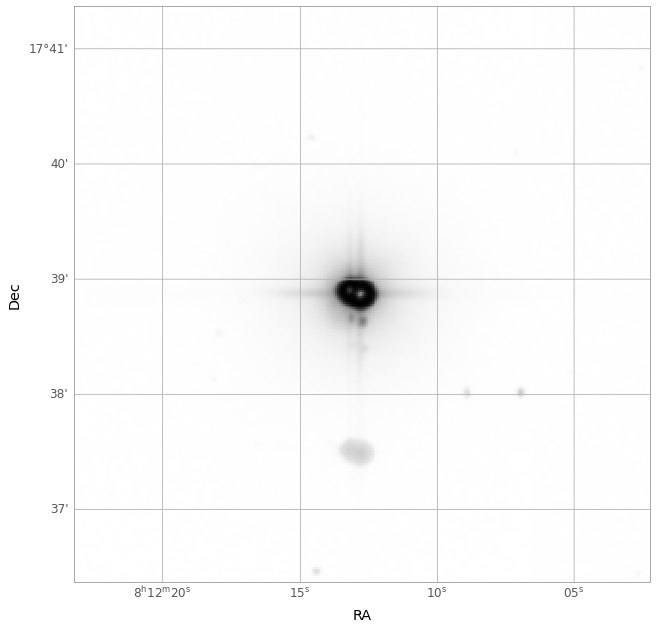

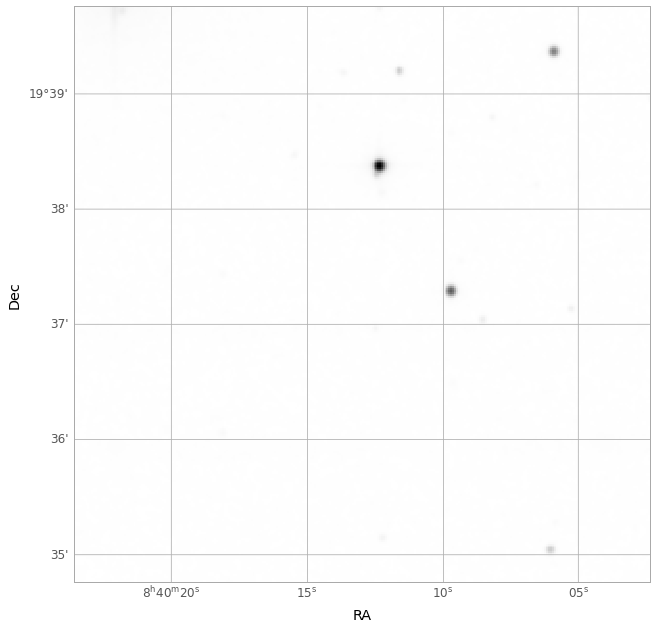

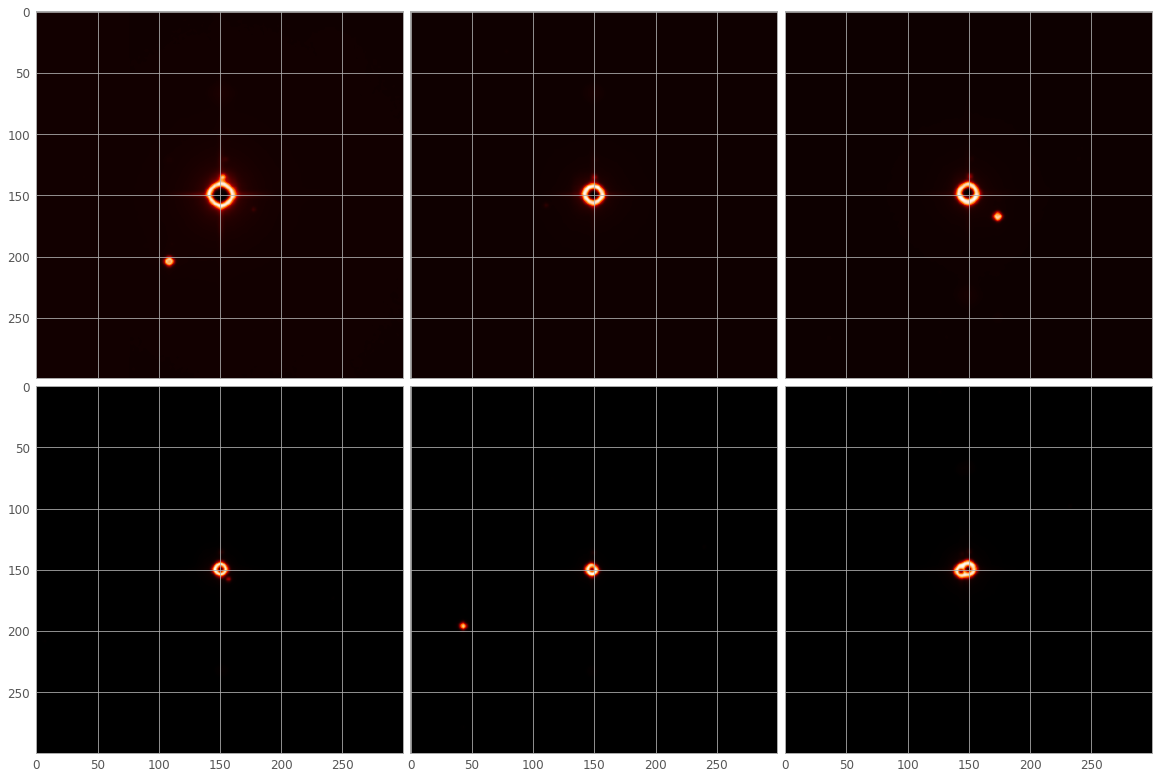

In [126]:
# Still in progress, trying to at least show images of the stars in question
# M44 is being clipped, probably a cleaner way to implement the grid/subplots
# Missing appropriate labels, tried to convert to RA/DEC projection, but kept getting errors
from mpl_toolkits.axes_grid1 import ImageGrid
imgs = []
centers = [coordinates.SkyCoord.from_name(star) for star in stars_in_cancer]
for i, center in enumerate(centers):
  # Grab an image from SkyView of the Orion KL nebula region
  imglist = SkyView.get_images(position=center, survey='2MASS-J')
  # Top approach will make separate RA/DEC images for each star, looks a little weird   
  fig = plt.figure(i, figsize=(10, 10))
  # the returned value is a list of images, but there is only one
  img = imglist[0]
  # 'img' is now a fits.HDUList object; the 0th entry is the image
  mywcs = wcs.WCS(img[0].header)
  # use astropy's wcsaxes tool to create an RA/Dec image
  ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=mywcs)
  ax.set_xlabel("RA")
  ax.set_ylabel("Dec")
  ax.imshow(img[0].data, cmap='gray_r', interpolation='none', origin='lower',
          norm=pl.matplotlib.colors.LogNorm()) 
  imgs.append(img[0].data) 


# This approach makes a subplot, but clips M44 and is missing RA/DEC projection
fig = plt.figure(figsize=(20,20))
for i, center in enumerate(centers):
  img = imglist[0]
  
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,3),  # creates 2x3 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in (zip(grid, imgs)):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()


##### VO Simple Cone Search
Not quite working as intended...missing value to correct for abs magnitude

In [ ]:
# Using simple VO Cone Search (no parallaxes, makes data wonky)
radius = '0.065 deg'
tables = {}

for star, coord in cancer_coords.items():
  tables[star] = ConeSearch.query_region(coord, radius)

# tables['Tarf'].colnames

Classification Codes:
0	Star
1	Galaxy
2	Blend
3	Non-Star
4	Unclassified
5	Defect

In [ ]:
# Print obj ID and Mag from above tables
trunc_mag = {}
id_sel = 'hstID'
colm_keep = [id_sel,'class', 'Mag', 'BMag', 'VMag', 'semiMajorAxis']
# mag_sel = ['UMag', 'BMag', 'VMag']
for s, t in tables.items():
  print(str(s) + ': ')
  # t[id_sel,'class', 'Mag', 'BMag', 'VMag', 'semiMajorAxis'].pprint()
  t[[col for col in colm_keep]].pprint()
  for i in range(len(t)):
    if t['class'][i] <= 2 and t['BMag'][i]-t['VMag'][i] < 15 and t['BMag'][i]-t['VMag'][i] > -10:
      tmp_str = t['hstID'][i]
      tmp_data = (t['Mag'][i], t['BMag'][i] - t['VMag'][i])
      trunc_mag[tmp_str] = tmp_data
  print()

Tarf: 
  hstID    class   Mag     BMag    VMag  semiMajorAxis
                   mag     mag     mag       pixel    
---------- ----- ------- ------- ------- -------------
N8A5000030     0   3.684   5.475   3.684           0.0
N8A5011235     0    3.52     5.0    3.52           0.0
  2MIA0HZ8     4  10.733   99.99   99.99           0.0
  2MIA0HZ3     4   6.085   99.99   99.99           0.0
  2MIA0IB9     4   13.31   99.99   99.99           0.0
  2MIA0IB7     4  13.302   99.99   99.99           0.0
  2MIA0IB8     4    14.2   99.99   99.99           0.0
  2MIA0HYZ     4  15.045   99.99   99.99           0.0
  2MIA0IB5     4   14.34   99.99   99.99           0.0
  2MIA0IB6     4  14.691   99.99   99.99           0.0
       ...   ...     ...     ...     ...           ...
N8A1015228     3 17.9524 20.4314   99.99       3.09915
N8A5001847     3 22.3372   99.99   99.99       1.53544
N8A2010643     3 21.8453   99.99   99.99       2.87259
N8A7000671     3 20.0386   99.99 19.0166       8.18089
N8A

In [ ]:
# Testing trunc_table function
keep_these = ['gsc2ID','class', 'Mag', 'BMag', 'VMag']

trunc_test = trunc_table(tables, keep_these, style='GSC2')
# trunc_test

In [ ]:
plt_mag = []
plt_bvi = []
# for k, v in trunc_mag.items():
for k, v in trunc_test.items():
  tmag, tbvi = v[0], v[1]
  plt_mag.append(tmag)
  plt_bvi.append(tbvi)
  # print(k, v)

# print(plt_mag, plt_bvi)

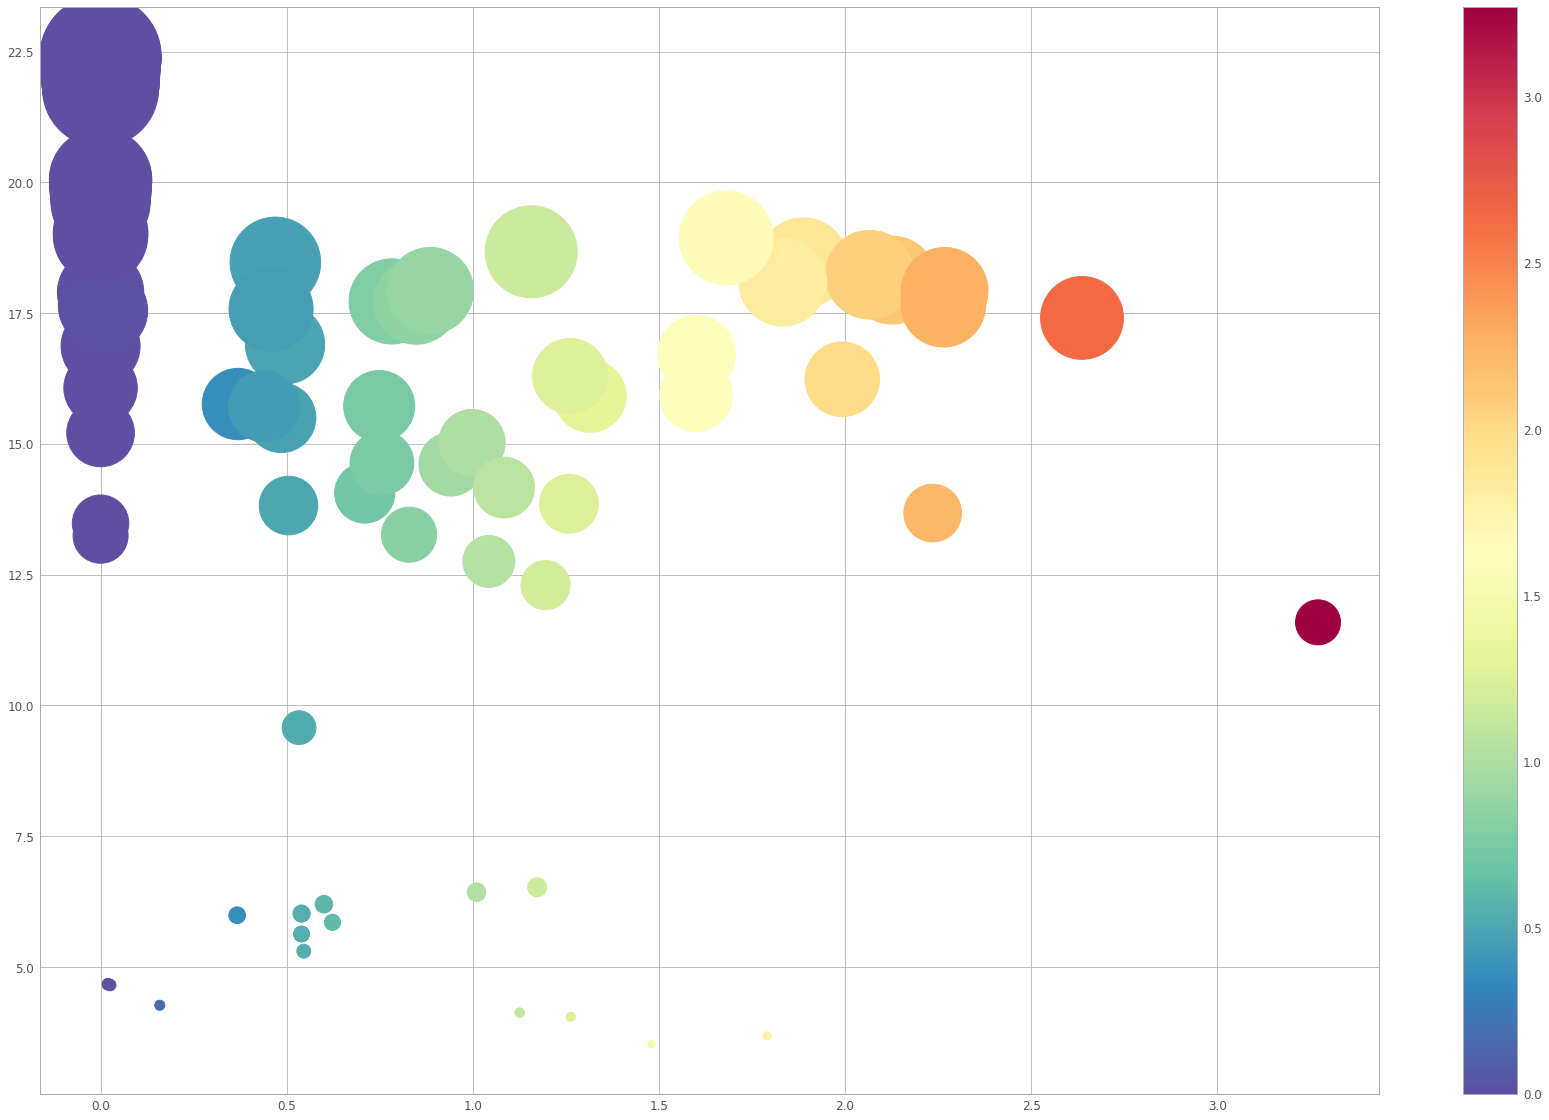

In [ ]:
fig = plt.figure(figsize=(30,20))
plt_s = 1.3*np.array(plt_mag)**3
plt.scatter(plt_bvi, plt_mag, c=plt_bvi, cmap='Spectral_r',s=plt_s)
plt.colorbar()

# Below plot looks wrong...hence the above switch to SIMBAD catalog for access to more data
# Not very accurate HR diagram (does not appear to approx. main sequence dist)

## Examples
Playing around with telescope queries, FITS data, etc...

### From astroquery sample gallery
Skyview img overlayed with plot of data from Vizier

(100.0, 200.0, 100.0, 200.0)

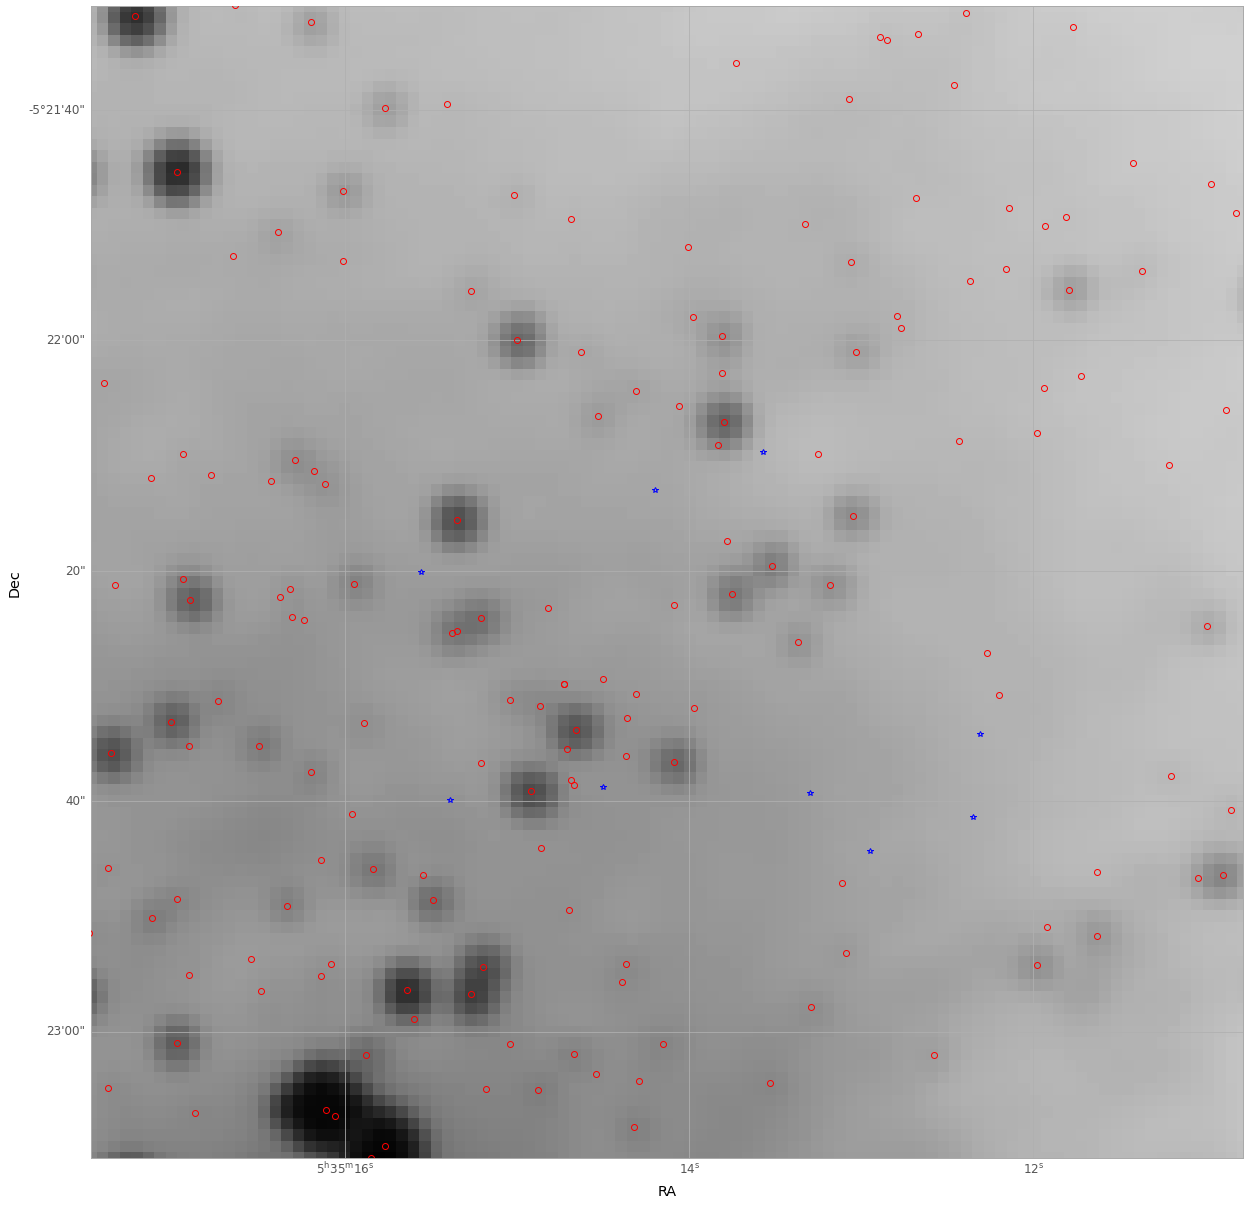

In [ ]:
center = coordinates.SkyCoord.from_name('Orion KL')

# Grab an image from SkyView of the Orion KL nebula region
imglist = SkyView.get_images(position=center, survey='2MASS-J')

# the returned value is a list of images, but there is only one
img = imglist[0]

# 'img' is now a fits.HDUList object; the 0th entry is the image
mywcs = wcs.WCS(img[0].header)
fig = pl.figure(1, figsize=(20,20))

fig.clf() # just in case one was open before
# use astropy's wcsaxes tool to create an RA/Dec image
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=mywcs)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.imshow(img[0].data, cmap='gray_r', interpolation='none', origin='lower',
          norm=pl.matplotlib.colors.LogNorm())


# retrieve a specific table from Vizier to overplot
tablelist = Vizier.query_region(center, radius=5*u.arcmin,
                                catalog='J/ApJ/826/16/table1')
# again, the result is a list of tables, so we'll get the first one
result = tablelist[0]

# convert the ra/dec entries in the table to astropy coordinates
tbl_crds = coordinates.SkyCoord(result['RAJ2000'], result['DEJ2000'],
                                unit=(u.hour, u.deg), frame='fk5')

# we want this table too:
tablelist2 = Vizier(row_limit=10000).query_region(center, radius=5*u.arcmin,
                                                  catalog='J/ApJ/540/236')
result2 = tablelist2[0]
tbl_crds2 = coordinates.SkyCoord(result2['RAJ2000'], result2['DEJ2000'],
                                 unit=(u.hour, u.deg), frame='fk5')


# overplot the data in the image
ax.plot(tbl_crds.ra, tbl_crds.dec, '*', transform=ax.get_transform('fk5'),
        mec='b', mfc='none')
ax.plot(tbl_crds2.ra, tbl_crds2.dec, 'o', transform=ax.get_transform('fk5'),
        mec='r', mfc='none')
# zoom in on the relevant region
ax.axis([100, 200, 100, 200])

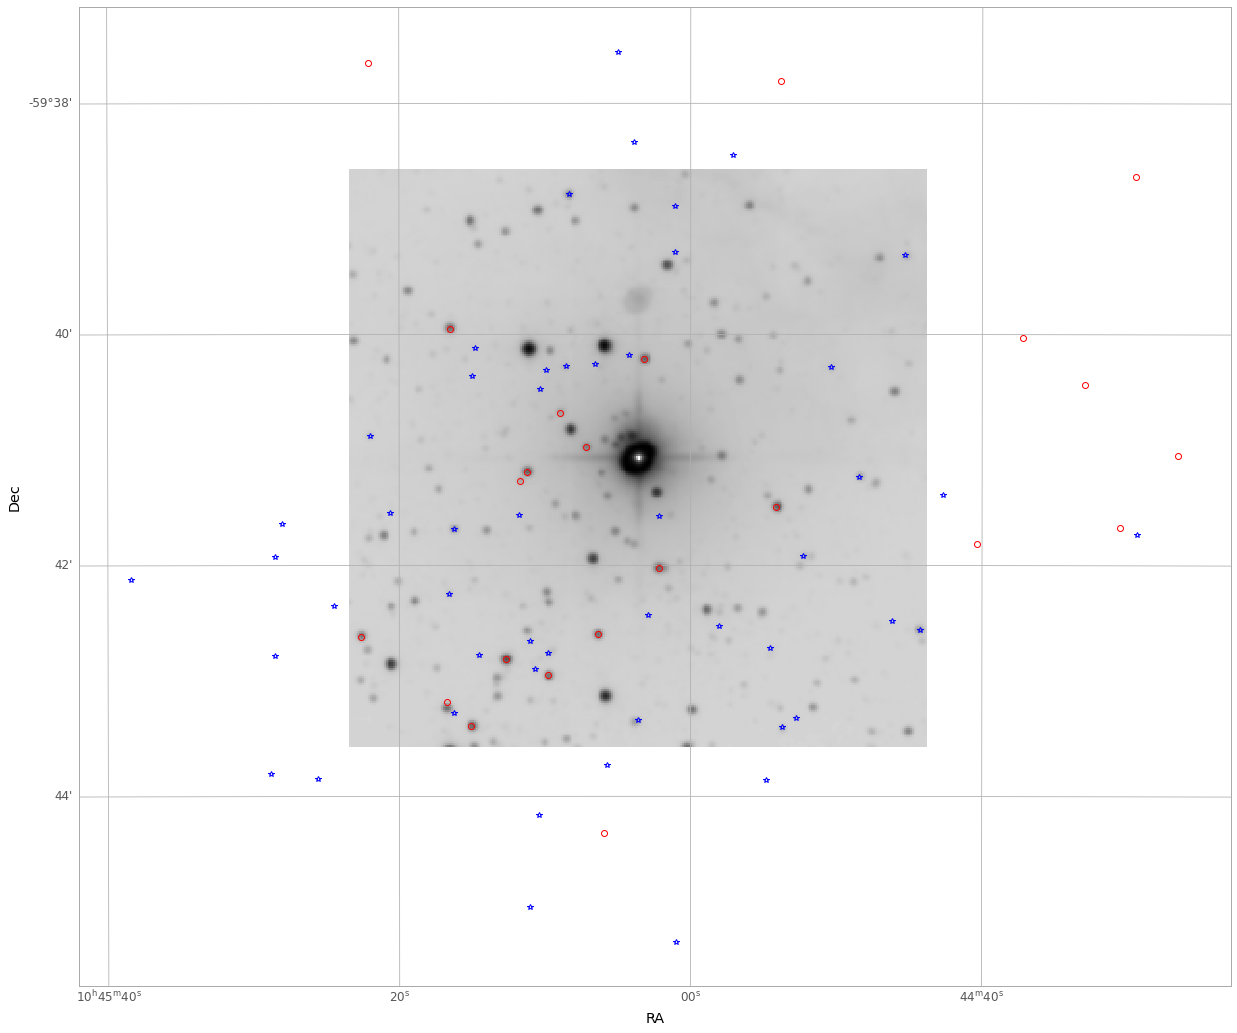

In [ ]:
# Changing Name in Query, just guessing with tables - not quite sure what the data being plotted represents
center = coordinates.SkyCoord.from_name('Eta Carinae')

# Grab an image from SkyView of the Orion KL nebula region
imglist = SkyView.get_images(position=center, survey='2MASS-J')

# the returned value is a list of images, but there is only one
img = imglist[0]

# 'img' is now a fits.HDUList object; the 0th entry is the image
mywcs = wcs.WCS(img[0].header)

fig = pl.figure(1, figsize=(20,20))
fig.clf() # just in case one was open before
# use astropy's wcsaxes tool to create an RA/Dec image
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=mywcs)

ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.imshow(img[0].data, cmap='gray_r', interpolation='none', origin='lower',
          norm=pl.matplotlib.colors.LogNorm())


# retrieve a specific table from Vizier to overplot
tablelist = Vizier.query_region(center, radius=5*u.arcmin,
                                catalog='J/ApJ/589/509/table5')
# again, the result is a list of tables, so we'll get the first one
result = tablelist[0]

# convert the ra/dec entries in the table to astropy coordinates
tbl_crds = coordinates.SkyCoord(result['RAJ2000'], result['DEJ2000'],
                                unit=(u.hour, u.deg), frame='fk5')

# we want this table too:
tablelist2 = Vizier(row_limit=10000).query_region(center, radius=5*u.arcmin,
                                                  catalog='J/ApJ/589/509/table7')
result2 = tablelist2[0]
tbl_crds2 = coordinates.SkyCoord(result2['RAJ2000'], result2['DEJ2000'],
                                 unit=(u.hour, u.deg), frame='fk5')


# overplot the data in the image
ax.plot(tbl_crds.ra, tbl_crds.dec, '*', transform=ax.get_transform('fk5'),
        mec='b', mfc='none')
ax.plot(tbl_crds2.ra, tbl_crds2.dec, 'o', transform=ax.get_transform('fk5'),
        mec='r', mfc='none')
# zoom in on the relevant region
# ax.axis([100, 200, 100, 200])

### Testing - MAST query (images)

In [ ]:
Observations.list_missions()

In [48]:
obs_table = Observations.query_criteria(
    # obs_collection=['JWST'],
    dataproduct_type=['image'],
    target_name=['*jupiter'],
    # target_name=['M44'],
    dataRights=['PUBLIC'],
    calib_level=[3, 4],
    # switch for saturn query (with wildcard*)
    # obs_title=['*saturn',],
) 

obs_table

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str4,str45,str33,float64,float64,float64,float64,float64,str8,str14,float64,float64,str32,str116,float64,str16,str19,str21,str5,str4,int64,str31,str7738,str140,str141,str6,bool,float64,str7,str8,str9
image,3,HST,ic3g01qqq,JUPITER,74.72297053262,21.87785121446,56189.99859795139,56189.99860366898,0.48,Optical,F763M,720.9,806.2,PLANET; THE BIG UY,The Jovian Transit of Venus - A Truth Test for Atmospheric Characterization of Earth-Size Planets in Habitable Zones,56190.08876162,WFC3/UVIS,"Schneider, Glenn",13067,GO/DD,HST,--,CALWF3,POLYGON 74.70942807796857 21.876164530750902 74.72413407407763 21.894054362460327 74.74445528901713 21.881548275204768 74.72974803479218 21.863660247219457 74.70942807796857 21.876164530750902,mast:HST/product/ic3g01qqq_drc.jpg,mast:HST/product/ic3g01qqq_drz.fits,PUBLIC,True,nan,science,23915239,139294115
image,3,HST,ic3g01qqq,JUPITER,74.72297053262,21.87785121446,56189.99859795139,56189.99860366898,0.48,Optical,F763M,720.9,806.2,PLANET; THE BIG UY,The Jovian Transit of Venus - A Truth Test for Atmospheric Characterization of Earth-Size Planets in Habitable Zones,56190.08876162,WFC3/UVIS,"Schneider, Glenn",13067,GO/DD,HST,--,CALWF3,POLYGON 74.70942807796857 21.876164530750902 74.72413407407763 21.894054362460327 74.74445528901713 21.881548275204768 74.72974803479218 21.863660247219457 74.70942807796857 21.876164530750902,mast:HST/product/ic3g01qqq_drc.jpg,mast:HST/product/ic3g01qqq_drz.fits,PUBLIC,True,nan,science,23915239,139294126
image,3,HST,ic3g02s1q,JUPITER,74.7260885855,21.8781030003,56190.05999834491,56190.06000405092,0.48,Optical,F763M,720.9,806.2,PLANET; THE BIG UY,The Jovian Transit of Venus - A Truth Test for Atmospheric Characterization of Earth-Size Planets in Habitable Zones,56190.22512731,WFC3/UVIS,"Schneider, Glenn",13067,GO/DD,HST,--,CALWF3,POLYGON 74.7125461069534 21.876416316583853 74.72725212901251 21.89430614830026 74.7475733798165 21.881800061027057 74.73286609962328 21.863912033057684 74.7125461069534 21.876416316583853,mast:HST/product/ic3g02s1q_drc.jpg,mast:HST/product/ic3g02s1q_drz.fits,PUBLIC,True,nan,science,23915247,139288285
image,3,HST,ic3g02s8q,JUPITER,74.72724261703,21.87819612332,56190.08278758102,56190.08279328704,0.48,Optical,F763M,720.9,806.2,PLANET; THE BIG UY,The Jovian Transit of Venus - A Truth Test for Atmospheric Characterization of Earth-Size Planets in Habitable Zones,56190.22721071,WFC3/UVIS,"Schneider, Glenn",13067,GO/DD,HST,--,CALWF3,POLYGON 74.71370012964569 21.876509439601254 74.72840616130252 21.89439927132024 74.74872742537114 21.881893184040507 74.73402013557346 21.86400515607703 74.71370012964569 21.876509439601254,mast:HST/product/ic3g02s8q_drc.jpg,mast:HST/product/ic3g02s8q_drz.fits,PUBLIC,True,nan,science,23915253,139286883
image,3,HST,ic3g02s8q,JUPITER,74.72724261703,21.87819612332,56190.08278758102,56190.08279328704,0.48,Optical,F763M,720.9,806.2,PLANET; THE BIG UY,The Jovian Transit of Venus - A Truth Test for Atmospheric Characterization of Earth-Size Planets in Habitable Zones,56190.22721071,WFC3/UVIS,"Schneider, Glenn",13067,GO/DD,HST,--,CALWF3,POLYGON 74.71370012964569 21.876509439601254 74.72840616130252 21.89439927132024 74.74872742537114 21.881893184040507 74.73402013557346 21.86400515607703 74.71370012964569 21.876509439601254,mast:HST/product/ic3g02s8q_drc.jpg,mast:HST/product/ic3g02s8q_drz.fits,PUBLIC,True,nan,science,23915253,139286889
image,3,HST,ic3g01qlq,JUPITER,74.72231001593,21.87779784375,56189.98583167824,56189.986171840275,29.4,Optical,F275W,243.20000000000002,305.8,PLANET; THE BIG UY,The Jovian Transit of Venus - A Truth Test for Atmospheric Characterization of Earth-Size 

In [49]:
data_prod = Observations.get_product_list(obs_table[1])

### Showing jpg




In [50]:
# Testing jpg display
data_filter = Observations.filter_products(data_prod,
    # productType='SCIENCE',
    extension='jpg',
    # calib_level=[3]
)

print(data_filter)

 obsID   obs_collection dataproduct_type ... parent_obsid dataRights calib_level
-------- -------------- ---------------- ... ------------ ---------- -----------
23915239            HST            image ...     23915239     PUBLIC           1
23915239            HST            image ...     23915239     PUBLIC           3
23915239            HST            image ...     23915239     PUBLIC           3
23915239            HST            image ...     23915239     PUBLIC           2
23915239            HST            image ...     23915239     PUBLIC           2


In [51]:
test_prod = Observations.download_products(data_filter[1])

Image size: 2176 x 2059
Image bands: ('L',)


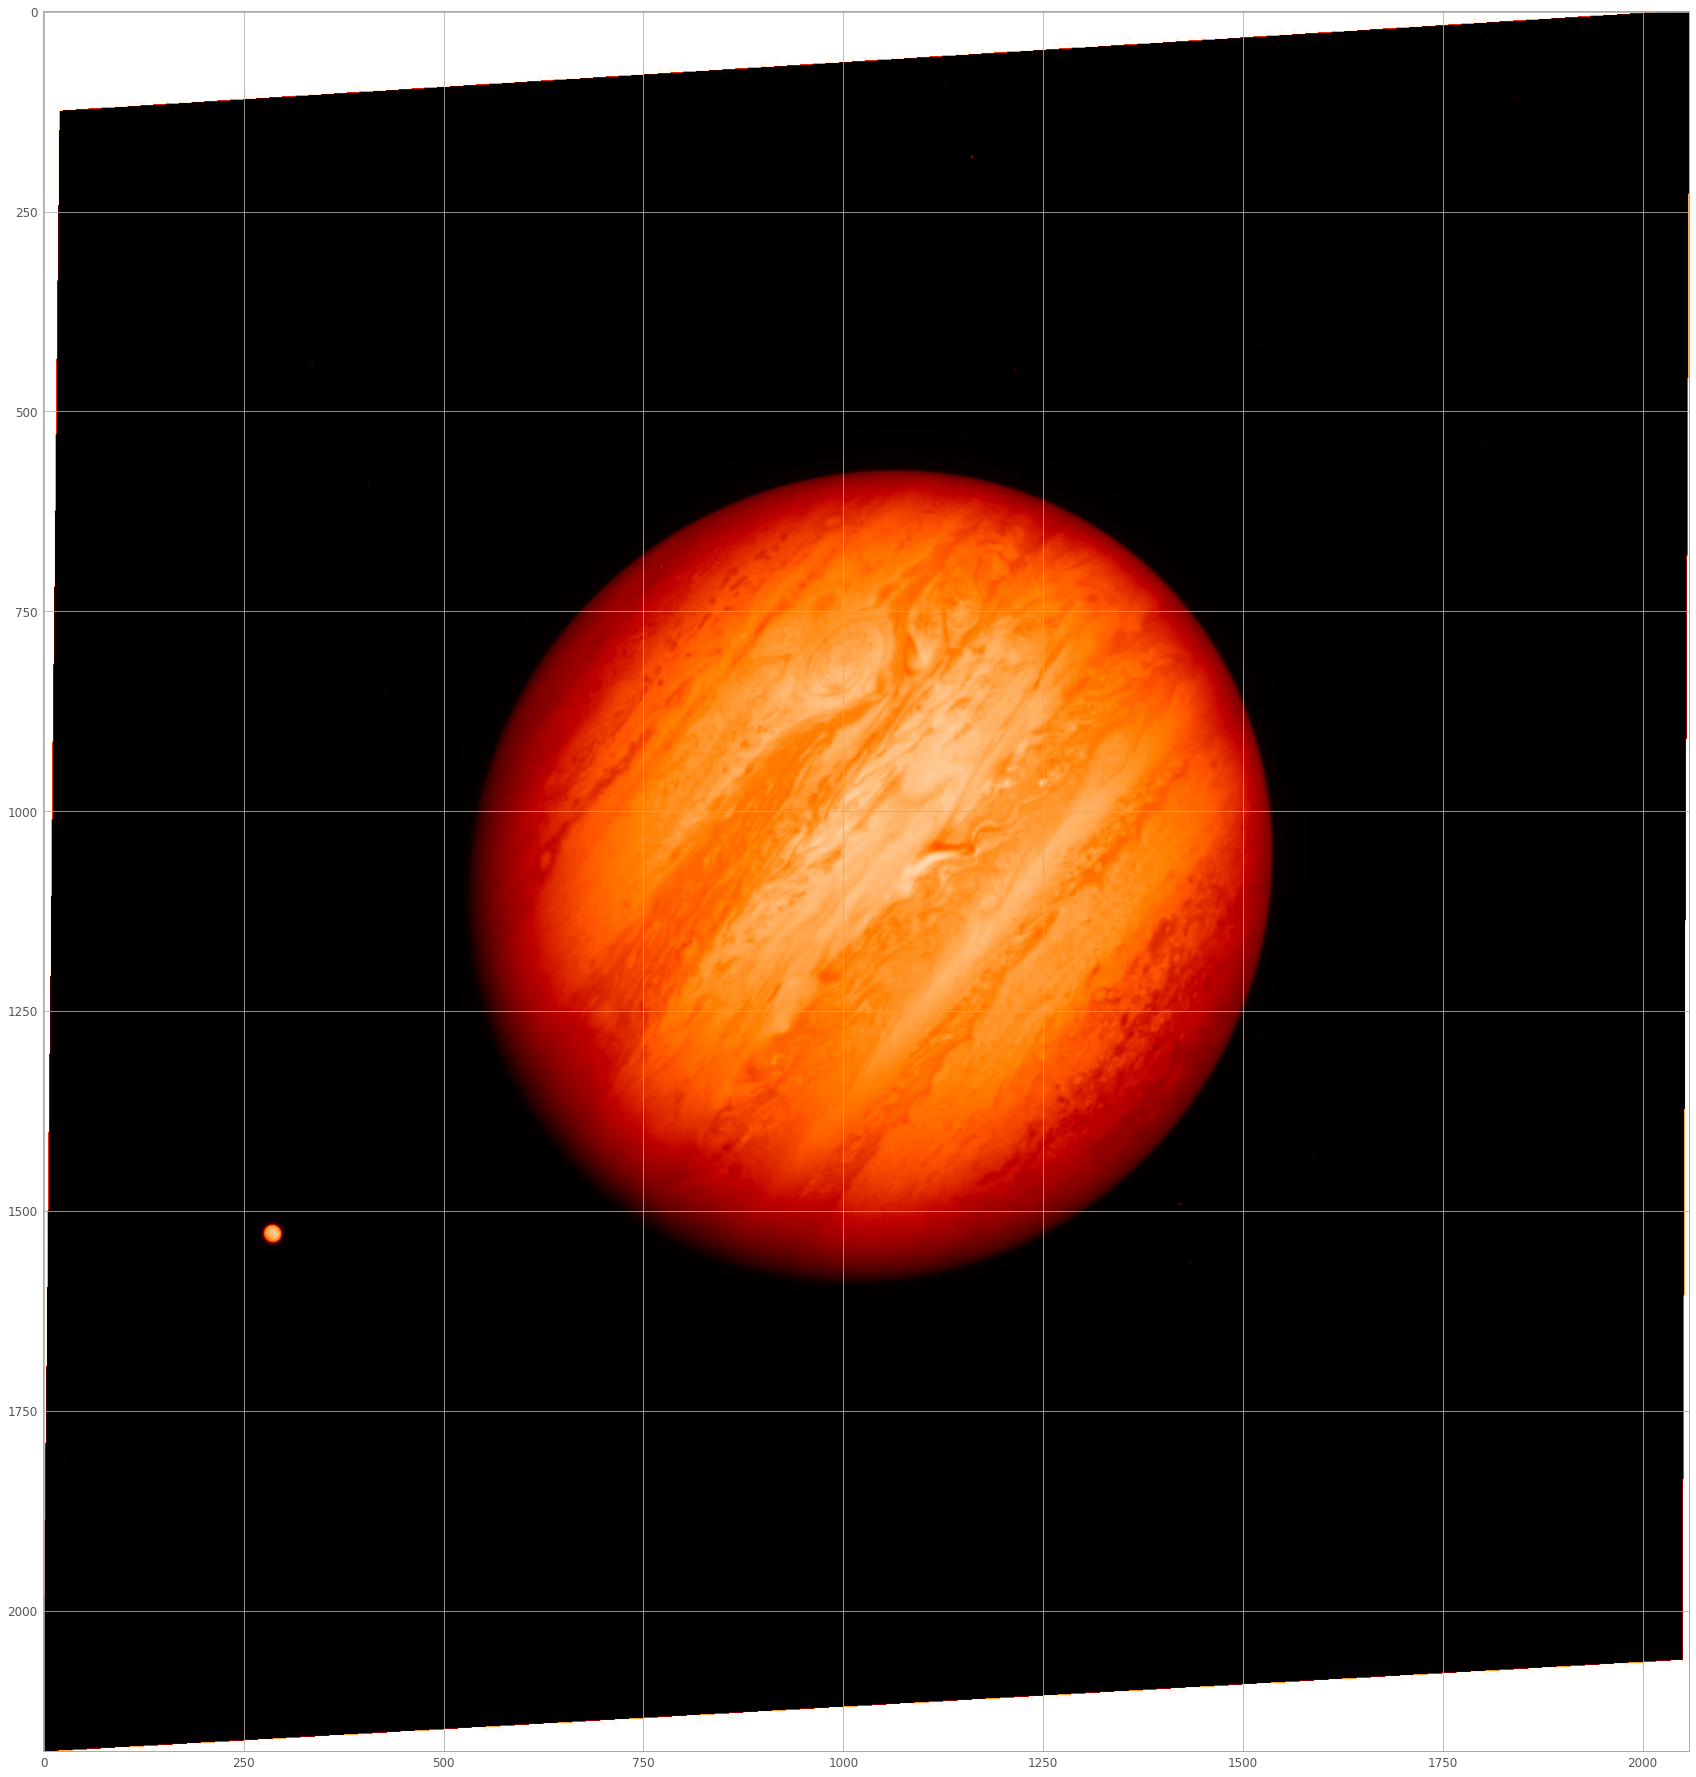

In [52]:
img = Image.open(test_prod[0][0])
xsize,ysize = img.size

print(f"Image size: {ysize} x {xsize}")
print(f"Image bands: {img.getbands()}")

fig = pl.figure(1, figsize=(32,32))
ax = plt.imshow(img)

### Plotting from fits

In [53]:
# Testing displaying fits img
data_filter = Observations.filter_products(data_prod,
    productType='SCIENCE',
    extension='fits',
    calib_level=[3,4]
)

print(data_filter)

 obsID   obs_collection dataproduct_type ... parent_obsid dataRights calib_level
-------- -------------- ---------------- ... ------------ ---------- -----------
23915239            HST            image ...     23915239     PUBLIC           3
23915239            HST            image ...     23915239     PUBLIC           3


In [54]:
test_prod = Observations.download_products(data_filter[0])

In [55]:
img_data = fits.getdata(test_prod[0][0]) # this indexing feels weird, doesn't always work, depending on catalogue
print(type(img_data), img_data.shape)

<class 'numpy.ndarray'> (2176, 2059)


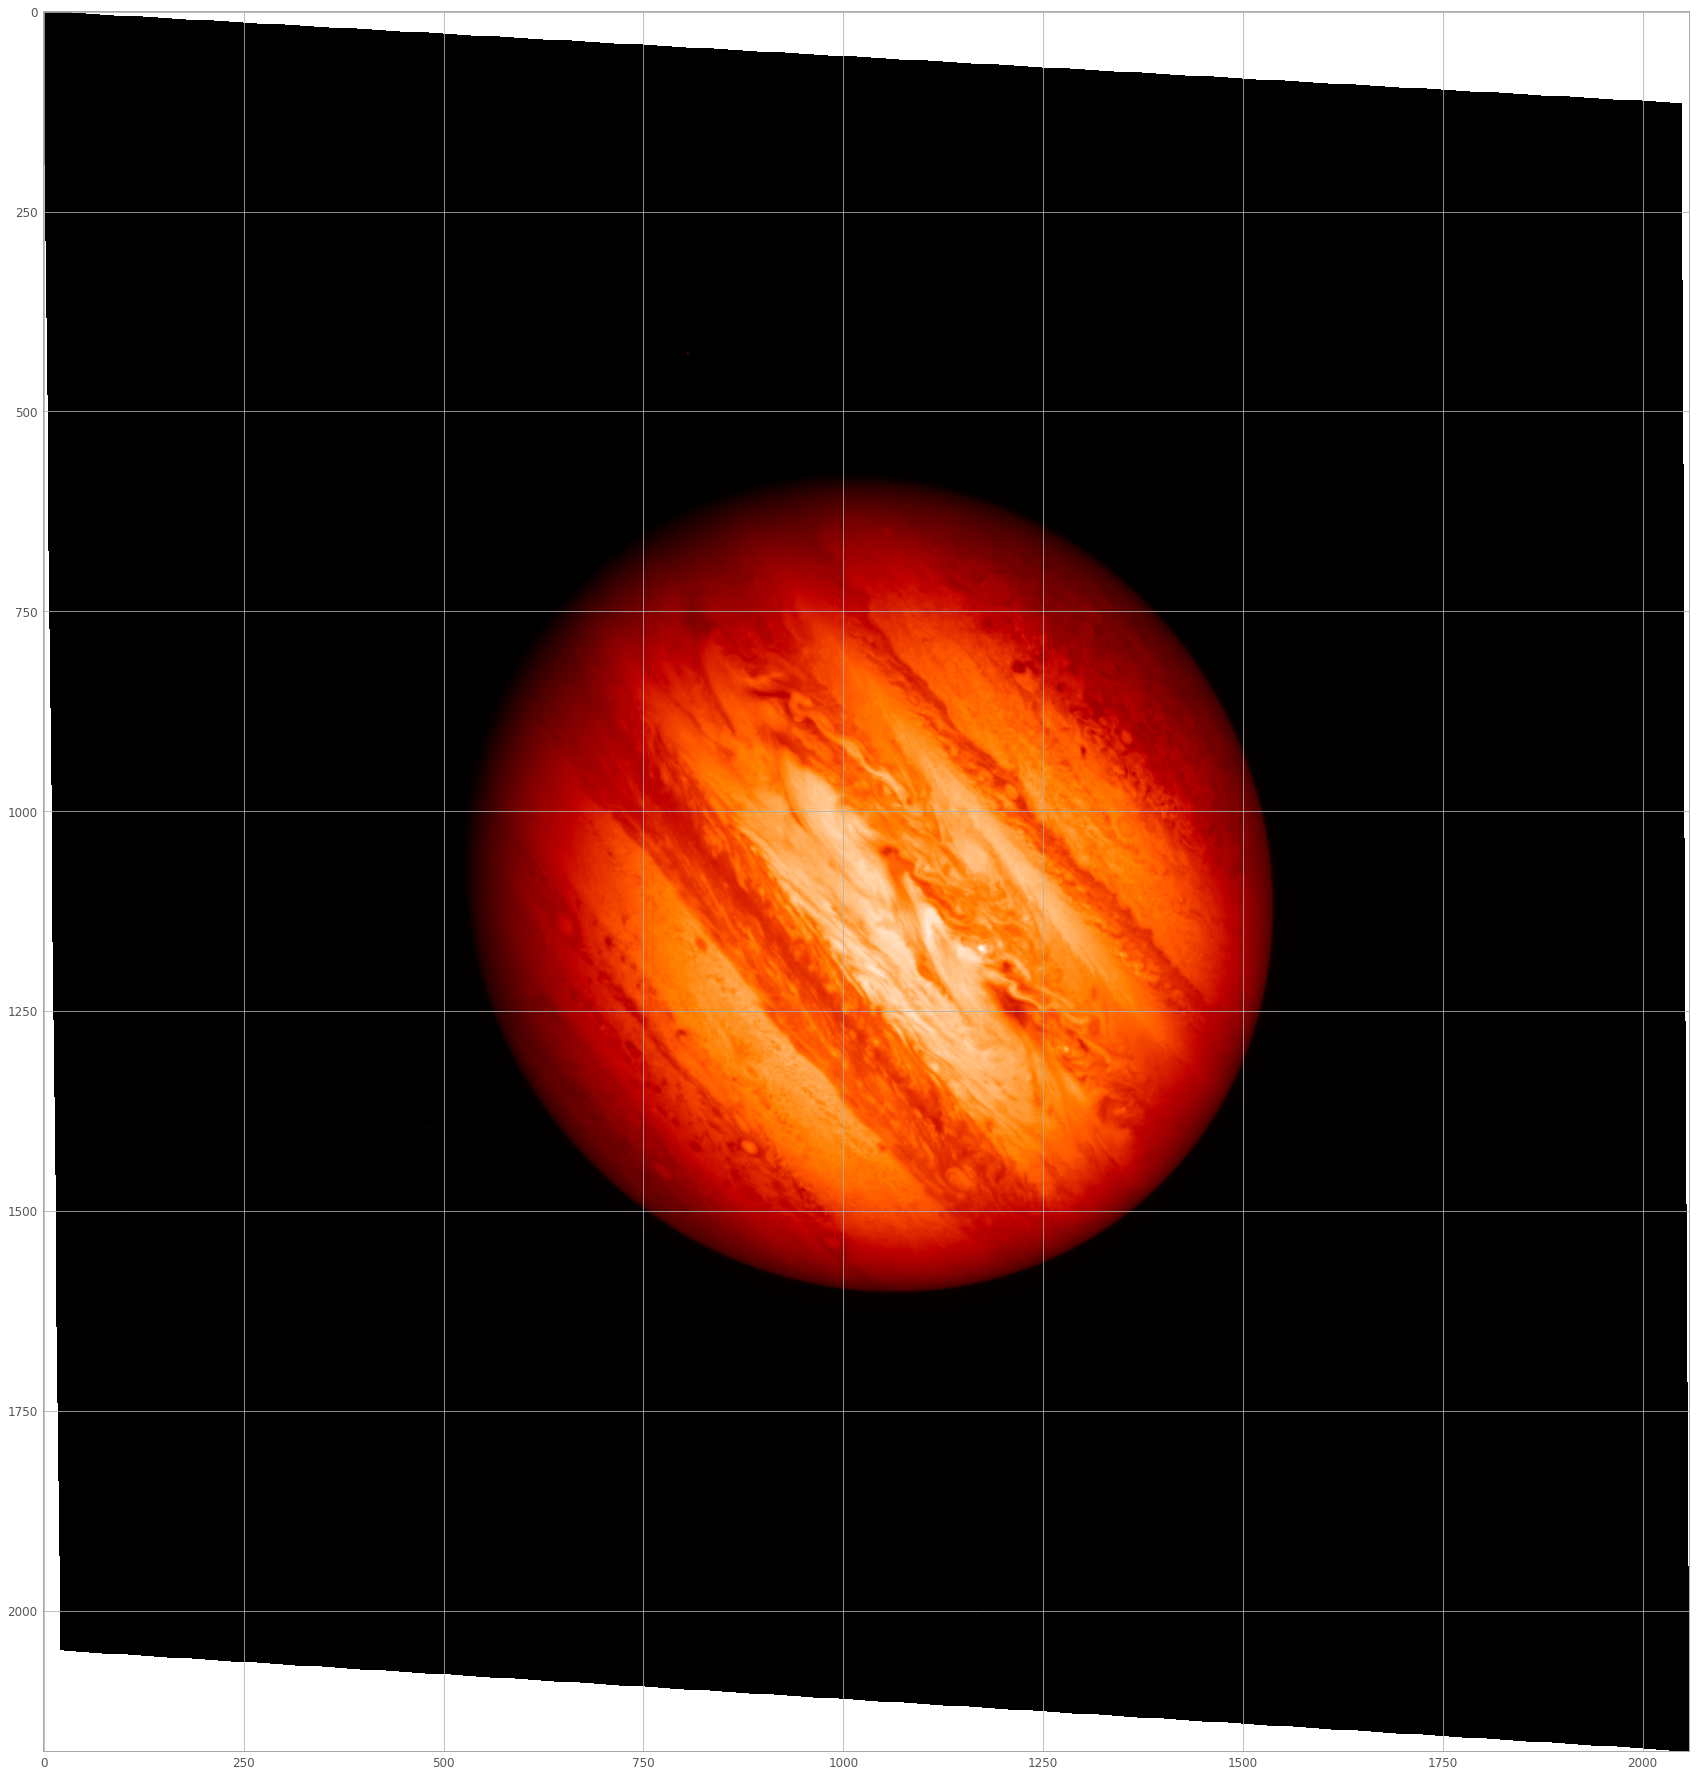

In [ ]:
fig = pl.figure(1, figsize=(32,32))
plt.imshow(img_data,
          #  cmap='gray',
           )